# Susceptible-Infected-Recovered model

In [3]:
from scipy.integrate import odeint, solve_ivp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from scipy.optimize import minimize
from scipy.optimize import Bounds

For this comparmental model, we choose to fit the parameters on the data on confirmed cases provided by the World Health Organization (WHO), collected by this site: https://ourworldindata.org/coronavirus-source-data 

In [21]:
df=pd.read_csv('data/total_cases.csv')
df['date']=pd.to_datetime(df['date'])
df.set_index('date',inplace=True)
country='Italy'
population=60480000.

# Start of the study (con be modified as wanted)
start = pd.Timestamp('2020-02-23')
end = pd.Timestamp('2020-03-15')
days=(end-start).days+1
t = np.linspace(start.value, end.value, days)
t = pd.to_datetime(t)

tempo=np.linspace(1,days,days)


Some explorations of the timeserie of the confirmed cases.

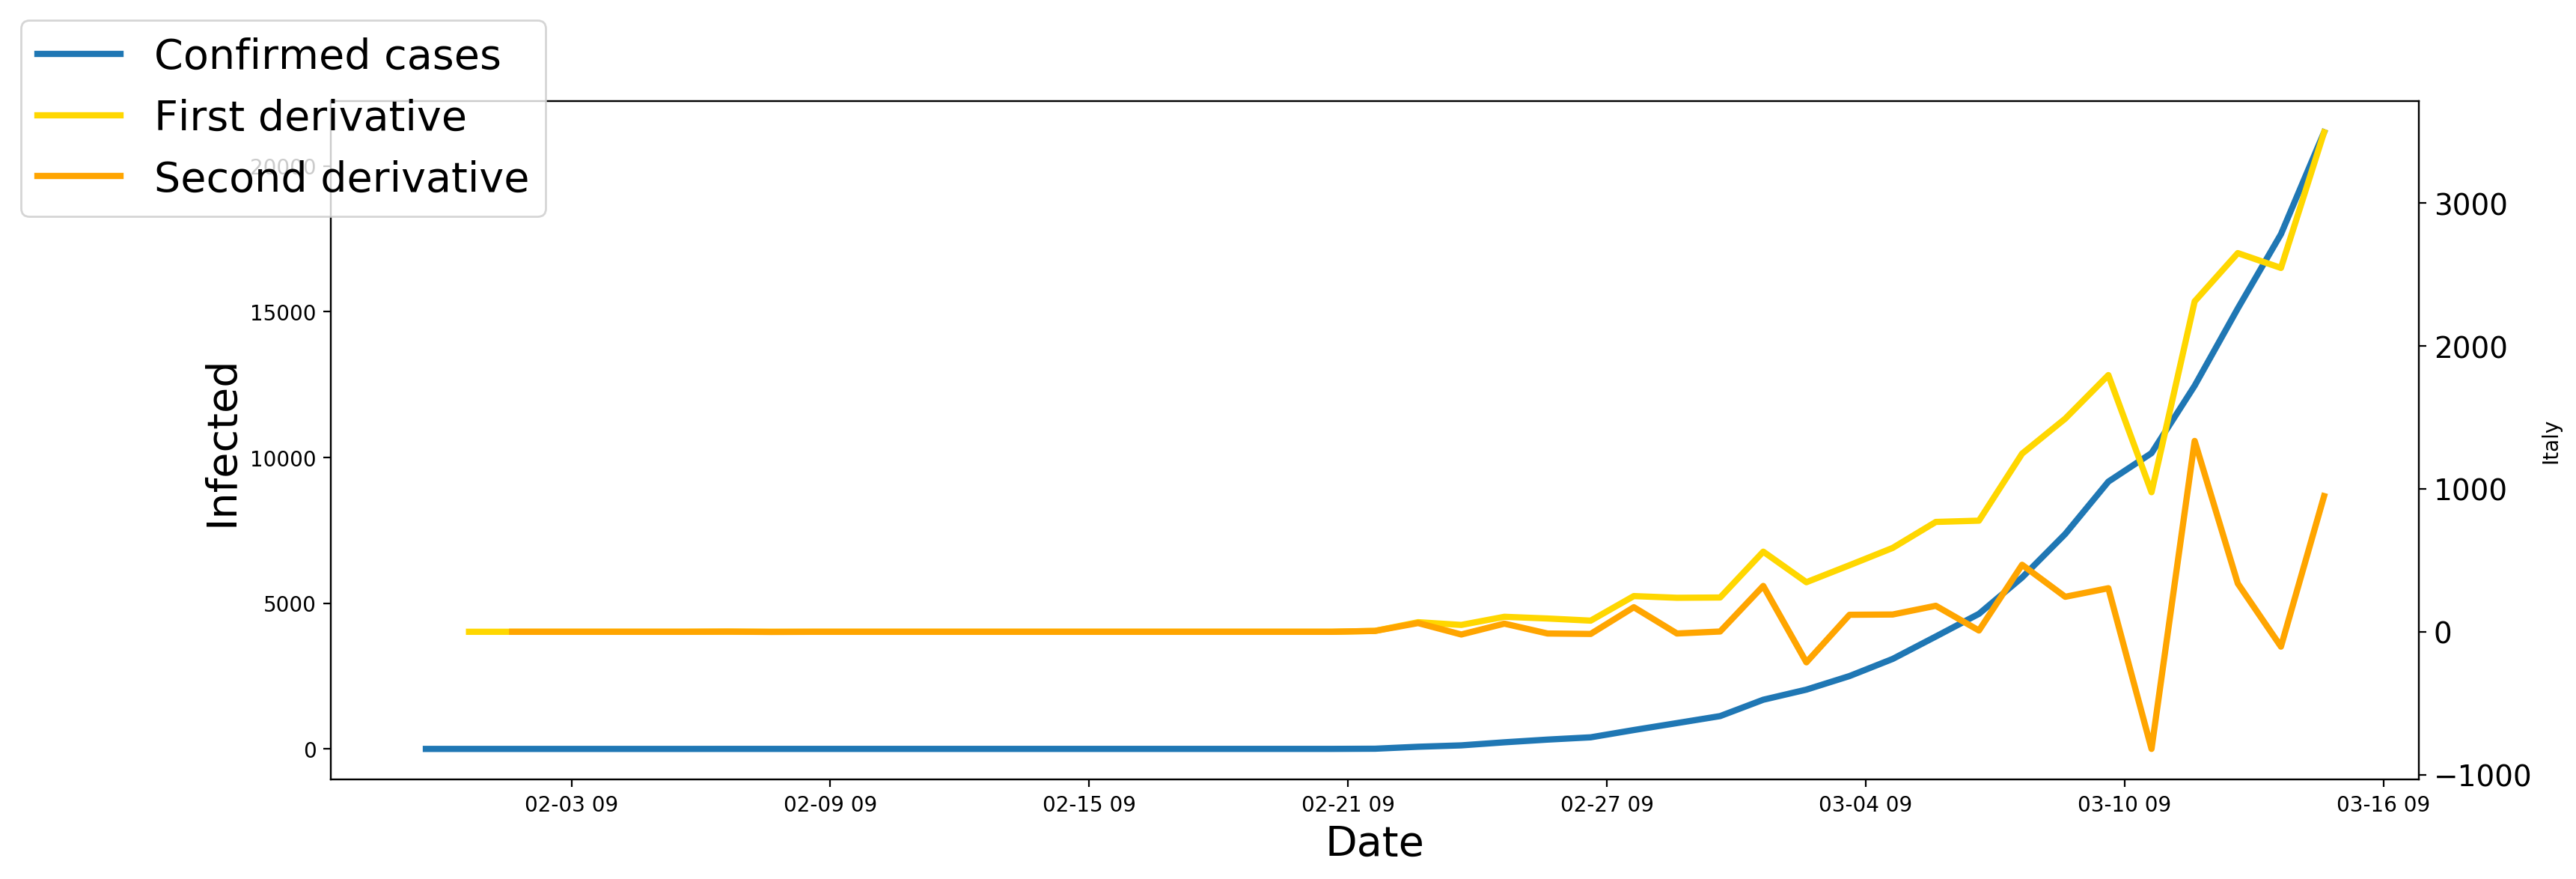

In [49]:
diff1=df[country].diff() #first derivative
diff2=diff1.diff() #second derivative

f,ax=plt.subplots(1,1,figsize=(18,6),dpi=200)
sns.lineplot(x=df.index,y=country,data=df,markers='o',
             label='Confirmed cases',ax=ax)
plt.setp(ax.lines,linewidth=3)

ax2 = ax.twinx()
sns.lineplot(x=diff1.index,y=diff1,ax=ax2,label='First derivative',color='gold')
sns.lineplot(x=diff2.index,y=diff2,ax=ax2,label='Second derivative',color='orange')
plt.setp(ax2.lines,linewidth=3)

#ax.lines[1].set_linestyle("--")
xticks=plt.xticks(rotation=50,fontsize=12)
yticks=plt.yticks(fontsize=14)
ax.set_xlabel('Date',fontsize=20)
ax.set_ylabel('Infected',fontsize=20)

#plt.yscale('log')
ax.xaxis.set_major_locator(mdates.HourLocator(interval=48*3))
#plt.setp(ax.get_legend().get_texts(), fontsize='20') # for legend text
#plt.setp(ax.get_legend().get_title(), fontsize='18') # for legend title
ax.get_legend().remove()
ax2.get_legend().remove()
ax2.figure.legend(loc='upper left',fontsize=20)


The model we choose is a Susceptible-Infected-Recovered (SIR).  
We specify that R0 is not directly a parameter of the model, but you can derive it from other model parameters. Since R0 has the easy-to-say meaning of "secundary cases from a single infected person", it is very popular during this outbreak, and it is very useful to describe the behaviour of the epidemiological curves. (https://www.icts.res.in/sites/default/files/PuneR0talk.pdf)

In the next chunk, we initialize the parameter we know from literature about COVID-19 (reference will be provided). We also set up some values as a starting point for the fit of the parameters we do not know the value of.

In [22]:
#Known parameters
days_inf=10
mu=1/days_inf


#initial guess for parameters to fit from data
R0=2.8
beta=mu*R0
I0=df[df.index==start][country].iloc[0]

The number of confirmed case is known, but it is almost certain that the number of real infected people is much higher than the number of confirmed cases. For this reason, we decide to retrieve the value of infected people at the beginning of the study ($I_0$) from the data, using the number of confirmed cases on the first day only as initial guessing.

In [23]:
print('Initial parameters: I0={}\nbeta={} mu={}'.format(I0, beta,mu))
N=population
x0=[N-I0,I0,0.]
print(x0)
bounds = Bounds([0.0, I0], [1.0, 10*I0])

Initial parameters: I0=76.0
beta=0.27999999999999997 mu=0.1
[60479924.0, 76.0, 0.0]


We have set initial conditions (that will be fitted to). We also defined some constraints for the interval of $\beta=[0.0,1.0]$ and $I_0=[I_0,10*I_0]$.

In [24]:
    
def sumsq(p):
    beta,I0=p
    x0=[N-I0,I0,0.]
    def SIR_ode(t,x):
        S,I,R=x
        dS=-beta*S*I/N
        dI=beta*S*I/N-mu*I
        dR=mu*I
        return [dS,dI,dR]
    sol=solve_ivp(SIR_ode,[0,days],x0,t_eval=np.arange(0,days+1,1))
    return(sum((sol.y[1][:df.loc[start:,country].shape[0]][::1]-
                df.loc[start:,country])**2))

msol = minimize(sumsq,[beta,I0],method='L-BFGS-B',
                options={'maxiter':10000},bounds=bounds)


beta,I0=msol.x
R0=beta/mu
print('\nFitted parameters:\nI0= ',I0)
print('beta:',beta,' , mu:',mu)
print('R0:',R0,' , days_ill: {}'.format(1/mu))


Fitted parameters:
I0=  405.2318673383941
beta: 0.289349032349364  , mu: 0.1
R0: 2.8934903234936398  , days_ill: 10.0


In [25]:
def SIR(x,tempo):
    S,I,R=x
    dS=-beta*S*I/N
    dI=beta*S*I/N-mu*I
    dR=mu*I
    return dS,dI,dR

x0=[N-I0,I0,0.]
integ = odeint(SIR, x0, tempo)
res=pd.DataFrame(integ,columns=['Susceptible','Infected','Recovered'])
res['Step']=tempo
res['Day']=t

[None, None]

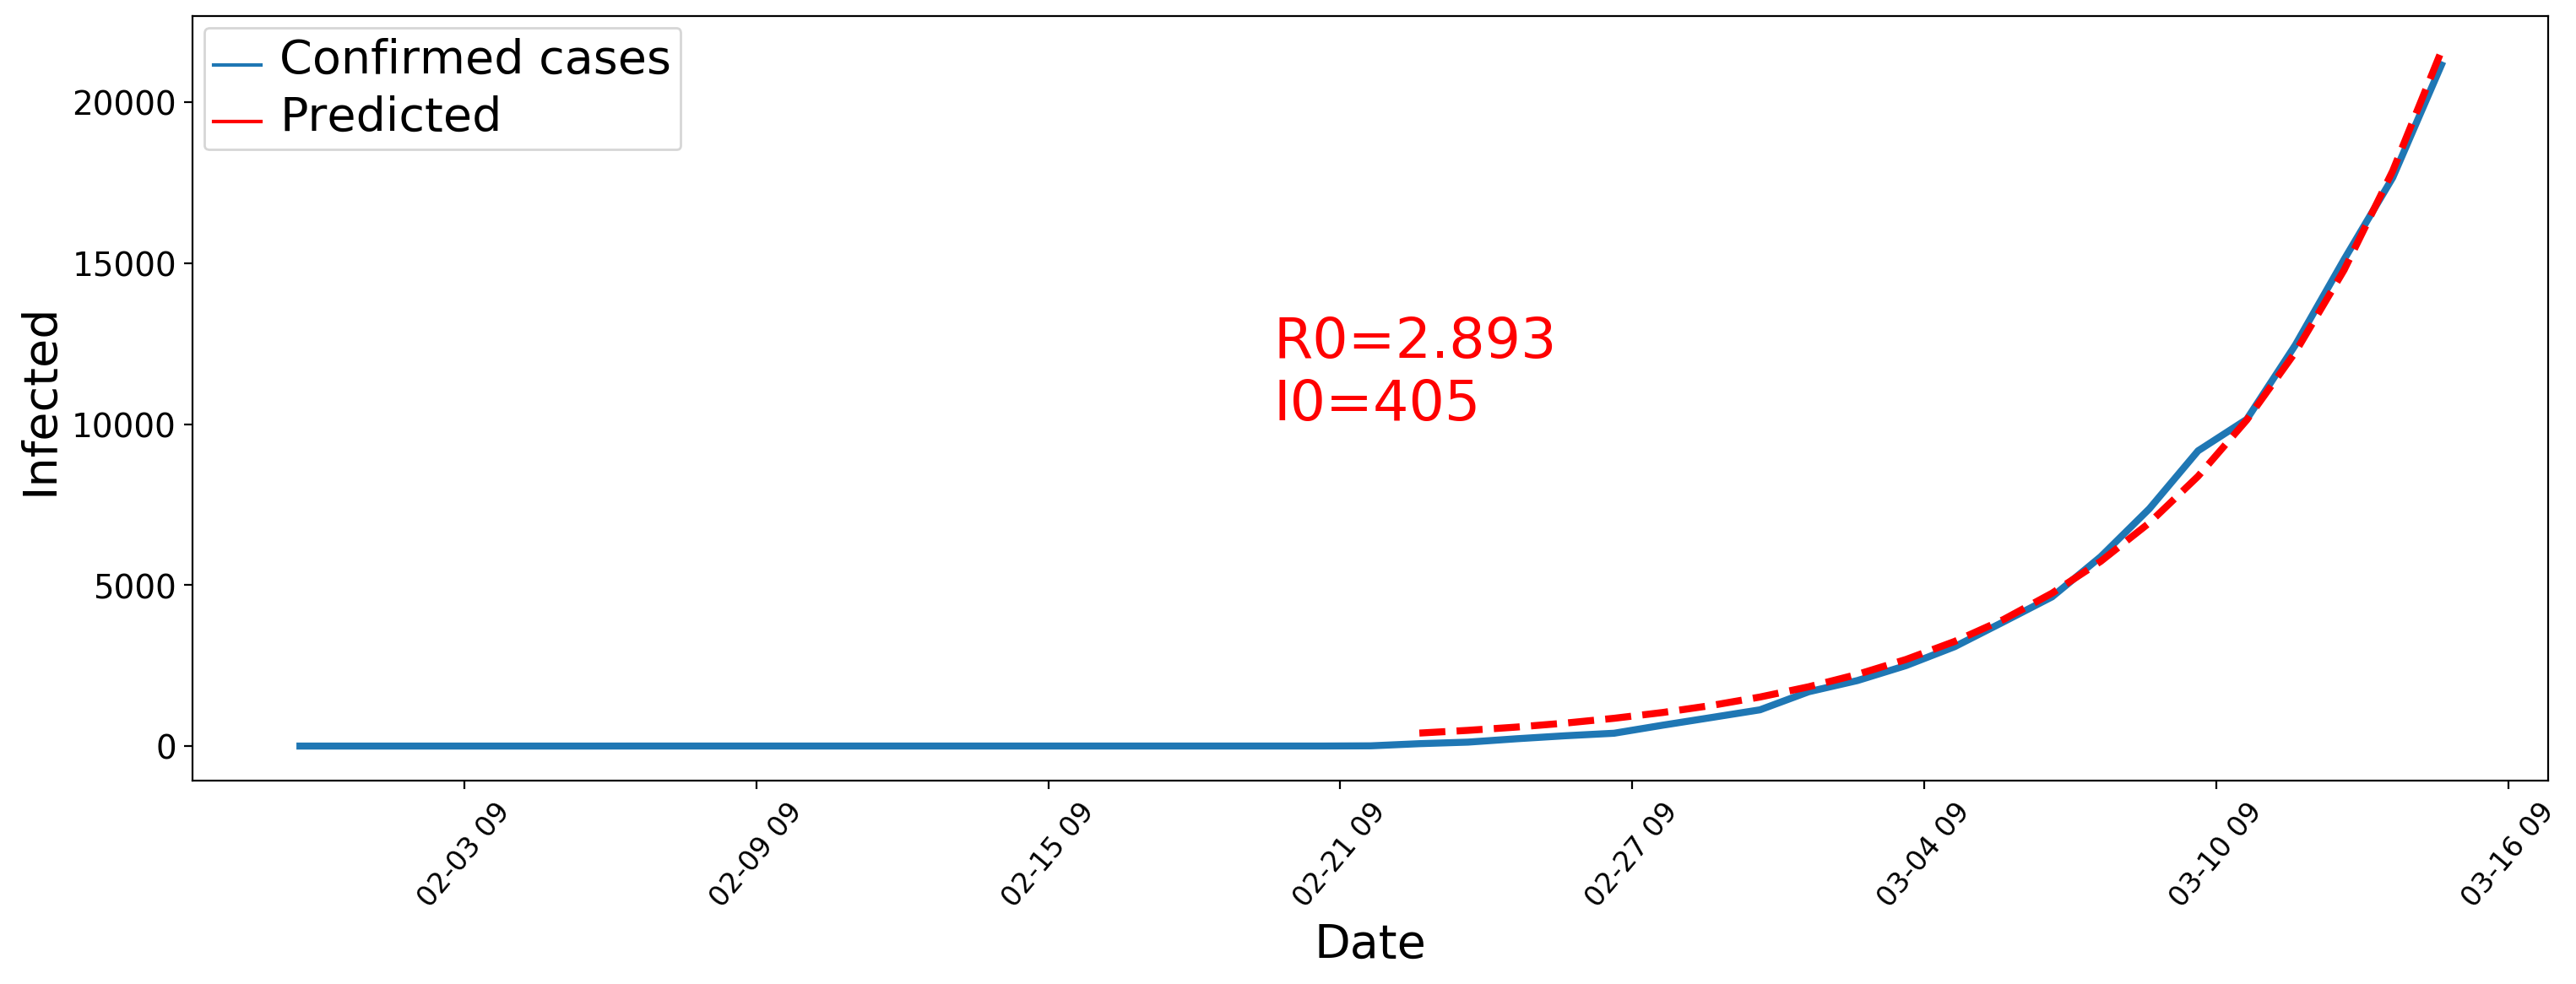

In [26]:
f,ax=plt.subplots(1,1,figsize=(18,6),dpi=200)
sns.lineplot(x=df.index,y=country,data=df,markers='o',ax=ax,
             label='Confirmed cases')
sns.lineplot(x='Day',y='Infected',data=res,ax=ax,label='Predicted',color='r')
plt.setp(ax.lines,linewidth=3)
ax.lines[1].set_linestyle("--")
xticks=plt.xticks(rotation=50,fontsize=12)
yticks=plt.yticks(fontsize=14)
ax.set_xlabel('Date',fontsize=20)
ax.set_ylabel('Infected',fontsize=20)
plt.annotate('R0={:1.3f}\nI0={}'.format(R0,int(I0)),
             xy=(mdates.date2num(df.index[30]), df[country][50]),
             fontsize=24,color='r')
#plt.yscale('log')
ax.xaxis.set_major_locator(mdates.HourLocator(interval=48*3))
plt.setp(ax.get_legend().get_texts(), fontsize='20') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='18') # for legend title

It's clear that, in order to fit the data, the number of initial infected people (405) is higher than the reported cases (76).

### Long time behaviour

[None, None]

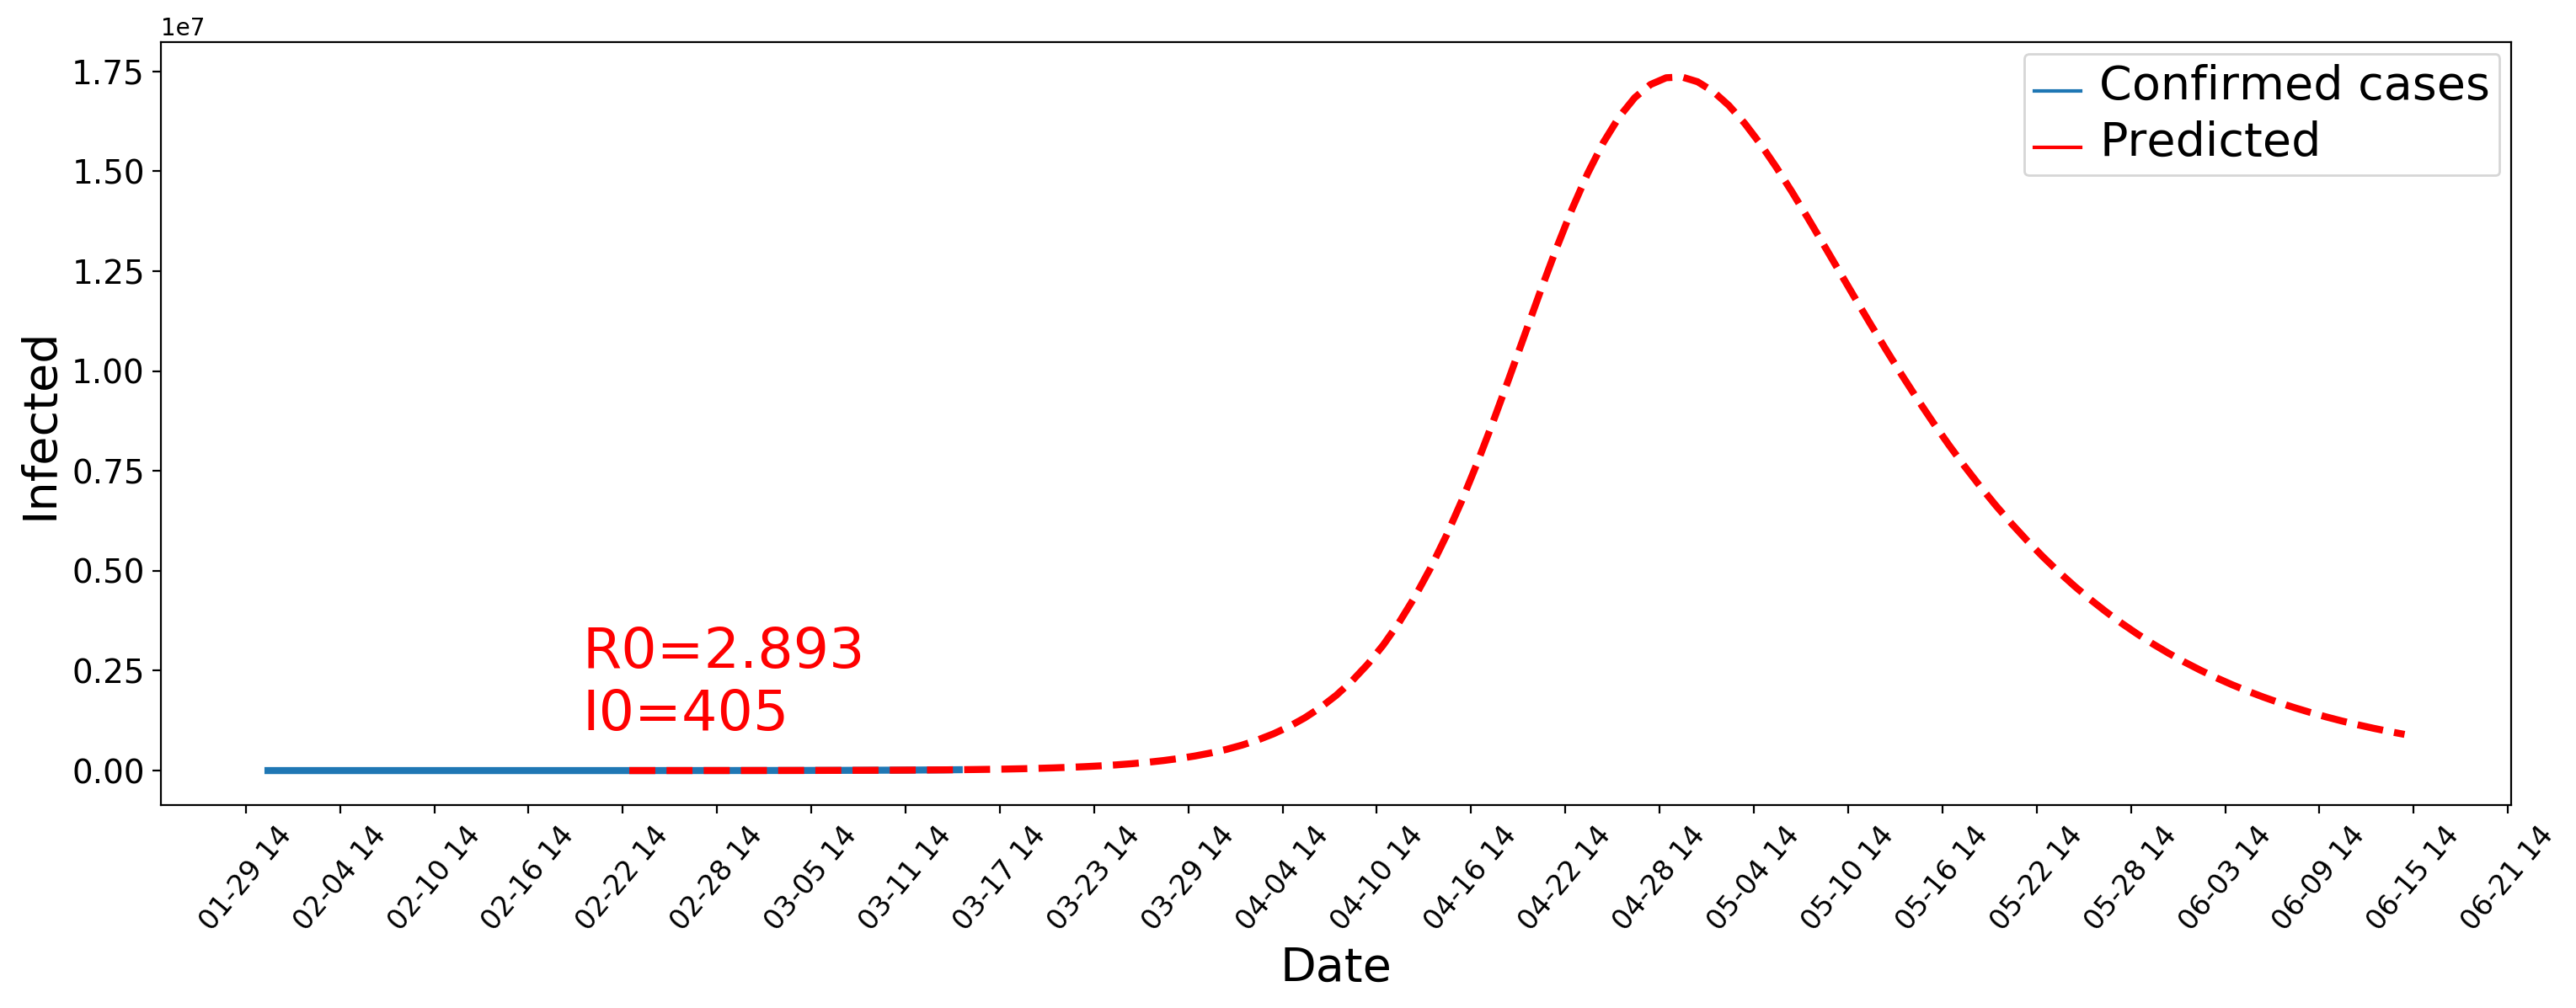

In [34]:
end = pd.Timestamp('2020-06-15')
days=(end-start).days+1
t_long = np.linspace(start.value, end.value, days)
t_long = pd.to_datetime(t_long)
tempo_long=np.linspace(1,days,days)


integ = odeint(SIR, x0, tempo_long)
res_long=pd.DataFrame(integ,columns=['Susceptible','Infected','Recovered'])
res_long['Step']=tempo_long
res_long['Day']=t_long

f,ax=plt.subplots(1,1,figsize=(18,6),dpi=200)
sns.lineplot(x=df.index,y=country,data=df,markers='o',ax=ax,
             label='Confirmed cases')
sns.lineplot(x='Day',y='Infected',data=res_long,ax=ax,label='Predicted',color='r')
plt.setp(ax.lines,linewidth=3)
ax.lines[1].set_linestyle("--")
xticks=plt.xticks(rotation=50,fontsize=12)
yticks=plt.yticks(fontsize=14)
ax.set_xlabel('Date',fontsize=20)
ax.set_ylabel('Infected',fontsize=20)
plt.annotate('R0={:1.3f}\nI0={}'.format(R0,int(I0)),
             xy=(mdates.date2num(df.index[30]), df[country][50]+1000000),
             fontsize=24,color='r')
#plt.yscale('log')
ax.xaxis.set_major_locator(mdates.HourLocator(interval=48*3))
plt.setp(ax.get_legend().get_texts(), fontsize='20') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='18') # for legend title